In [442]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from yellowbrick.classifier.rocauc import roc_auc

from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

# Group label prediction

Создадим функции для обработки данных и визуализации результатов моделей.

In [443]:
def model_preprcessing(posts, scaler):
    X = posts[['post_source', 'comments', 'likes', 'reposts', 'day_of_week', 'hour', 'word_num_desc', 'comment_likes', 'cluster']]
    y = posts['group_names_y']
    X = pd.get_dummies(X, columns=['cluster', 'post_source', 'day_of_week', 'hour'])
    if scaler == 'standard':
        standard_scaler = StandardScaler()
        X[['comments', 'likes', 'reposts', 'word_num_desc', 'comment_likes']] = standard_scaler.fit_transform(X[['comments', 'likes', 'reposts', 'word_num_desc', 'comment_likes']])
    if scaler == 'min_max':
        min_max = MinMaxScaler()
        X[['comments', 'likes', 'reposts', 'word_num_desc', 'comment_likes']] = min_max.fit_transform(X[['comments', 'likes', 'reposts', 'word_num_desc', 'comment_likes']])
        
    
    return X, y

In [485]:
def validation(model, params, X, y, cv=5):
    
    clf = GridSearchCV(model, param_grid=params, cv=cv, verbose=True, n_jobs=-1)
    
    fited = clf.fit(X, y)
    
    
    return fited

In [445]:
def stat_of_clf(best_estim, X_train, y_train, X_test, y_test):
    y_pred = best_estim.predict(X_test)
    y_prob = best_estim.predict_proba(X_test)
    
    confusion_matrix(y_test,y_pred)
    display(pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True))
    
    
    print(classification_report(y_test, y_pred))
    
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    viz = PrecisionRecallCurve(best_estim,
        cmap="Set1"
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
    viz = PrecisionRecallCurve(best_estim,per_class=True,classes=['FTP', 'MDK', 'NR', 'Reddit', 'ВПШ', 'На приеме у шевцова', 'Овсянка',
    'Рифмы и панчи'],
        cmap="Set1"
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
    
    
    roc_auc(best_estim, X_train, y_train, X_test=X_test, y_test=y_test, classes=['FTP', 'MDK', 'NR', 'Reddit', 'ВПШ', 'На приеме у шевцова', 'Овсянка',
    'Рифмы и панчи'])
    

In [448]:
comments = pd.read_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\processed comment data.csv', index_col=[0])
posts = pd.read_csv(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\парсинг вк\group_data_processed', index_col=[0])

In [449]:
comments = comments.rename({'likes': 'comment_likes', 'text': 'comment_text', 'post_id':'id'}, axis='columns')

Объединим данные о постах с датасетом комментариев, обработанном в предыдущем ноутбуке

In [450]:
posts = posts.merge(comments, on='id', how='inner')

In [451]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7564 entries, 0 to 7563
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7564 non-null   int64  
 1   owner_id       7564 non-null   int64  
 2   date           7564 non-null   object 
 3   marked_as_ads  7564 non-null   int64  
 4   post_type      7564 non-null   object 
 5   text           4189 non-null   object 
 6   post_source    7564 non-null   object 
 7   comments       7564 non-null   int64  
 8   likes          7564 non-null   int64  
 9   reposts        7564 non-null   int64  
 10  copyright      7564 non-null   object 
 11  is_pinned      7564 non-null   float64
 12  group_names_x  7564 non-null   object 
 13  day            7564 non-null   object 
 14  hour           7564 non-null   int64  
 15  day_of_week    7564 non-null   int64  
 16  word_num_desc  7564 non-null   int64  
 17  comment_text   7561 non-null   object 
 18  comment_

Применим функцию обработку данных и разобьем выборку на тренировочную и тестовую. Несмотря на то, что каждую модель мы будем кросс валидировать, необходимо часть выборки скрыть от модели во избежание переобучения.

In [452]:
X, y = model_preprcessing(posts, scaler='standard')

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [454]:
X_train.head()

,comments,likes,reposts,word_num_desc,comment_likes,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
6967,2.454624,0.526294,2.954528,-0.130060,3.883065,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
5828,-0.224073,0.864814,-0.141887,-0.509503,-0.146348,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7086,-0.410959,-0.683206,-0.006313,0.312624,-0.466888,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5586,-0.457680,0.853080,-0.580218,0.186143,-0.079475,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6698,-0.494019,-0.580167,1.757547,-0.509503,-0.498171,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


После применения обработки, в данных теперь 48 переменных. Попробуем сжать размерность с помощью алгоритмов TSNE и PCA, чтобы изобразить данные на двумерном скаттерплоте

In [455]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X)


<AxesSubplot:>

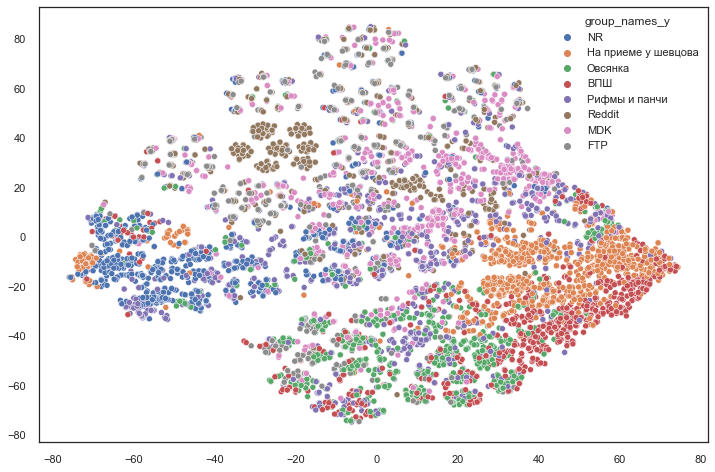

In [456]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:,1], y=X_embedded[:,0], hue=y)

TSNE очень сложно как либо интерпретировать, так как расстояние между группами наблюдений при снижении размерности мало что значит, при этом мы можем увидеть некоторые кластера из точек, которые являются определенной группой.

In [457]:
X_reduced = PCA(n_components=2).fit_transform(X)


<AxesSubplot:>

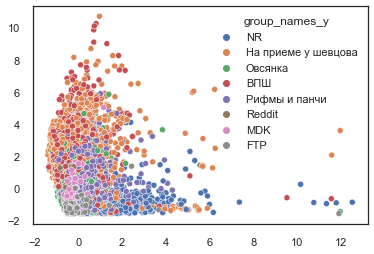

In [458]:
sns.scatterplot(x=X_reduced[:,1], y=X_reduced[:,0], hue=y)

# Model implementetion


Модели:
Logistic Regression,
KNN,
Support Vector Machines,
Decision Tree,
Random Forrest.

Для каждого алгоритма сначала построим базовую модель, затем произведем кросс валидацию.

## Logistic Regression

In [459]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

0.7726371447455387

In [460]:
params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'max_iter' : [100, 1000,1500]
    }
]

clf = validation(model=LogisticRegression(), params=params, X=X_train, y=y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this trai

In [461]:
best_estim = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)

0.7649952569763394
{'max_iter': 1000, 'penalty': 'none'}


Логистическую регрессию хорошо использовать для первичной оценки данных. Она отлично подходит для отбора переменных, так как ее коэффициенты показывают важность признаков. Положительный логирфм шансов увеличивает вероятность принадлежности объекта к определенному классу, отрицательный-уменьшает.

Попробуем визуализировать коэффициенты модели отдельно для каждой группы.

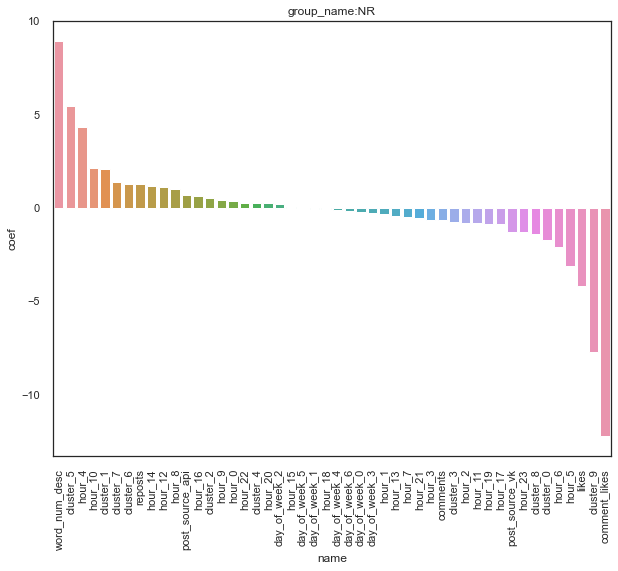

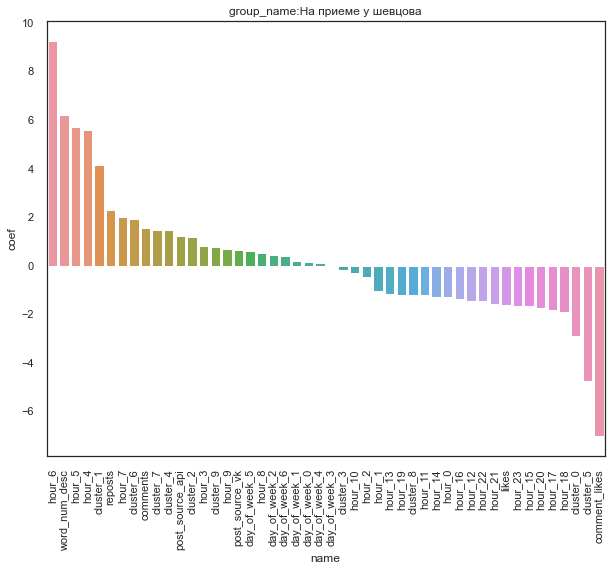

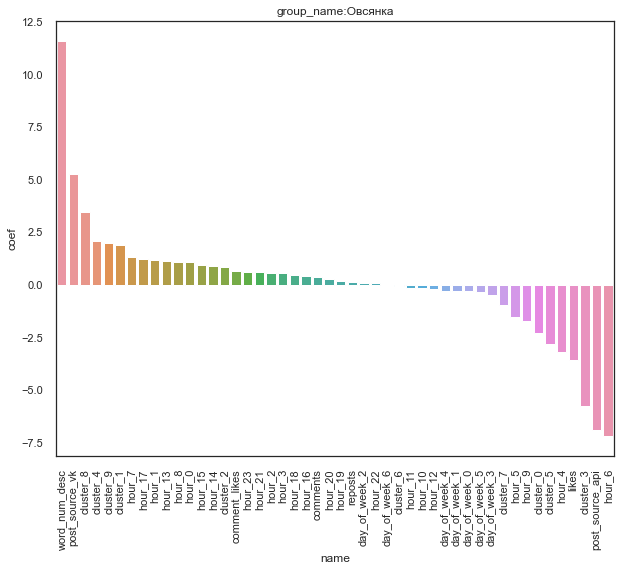

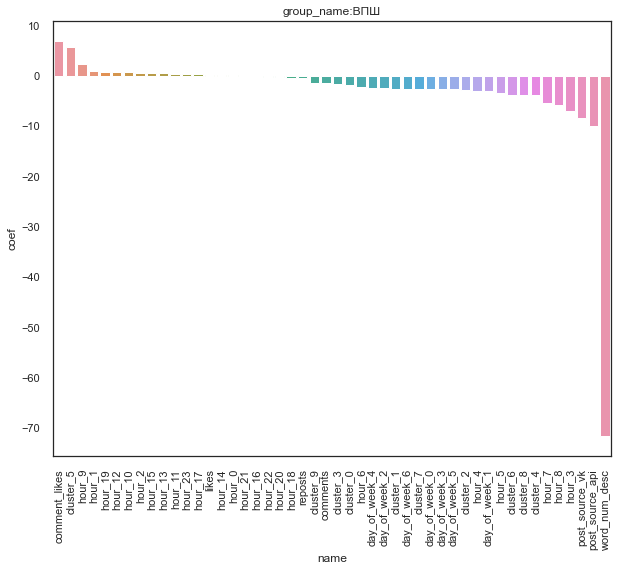

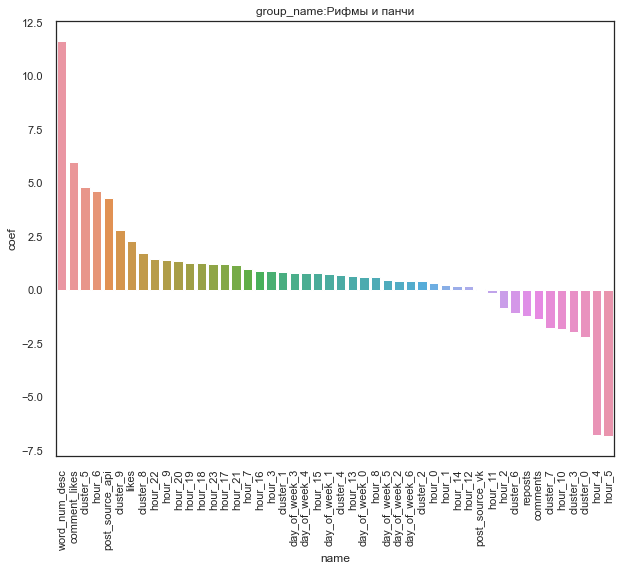

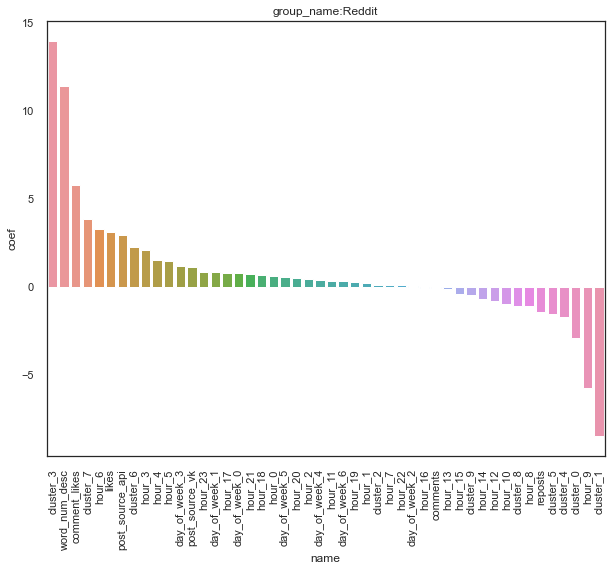

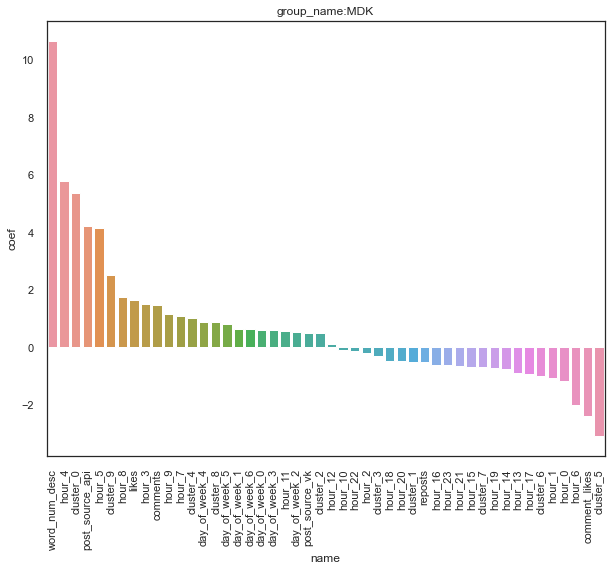

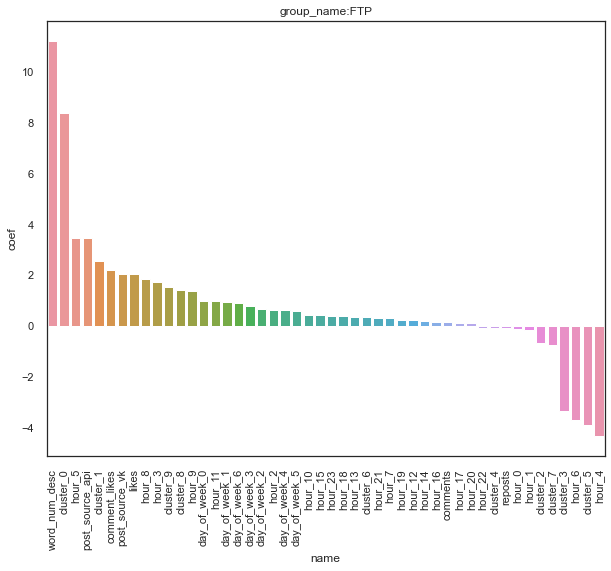

In [462]:

for i, col in enumerate(posts.group_names_y.unique()):
    coef = best_estim.coef_[i]
    name = X.columns
    features = pd.DataFrame({'coef':coef, 'name':name}).sort_values(by='coef', ascending=False)
    plt.figure(figsize=(10,8))
    sns.barplot(data=features, x='name', y='coef')
    plt.title('group_name:{}'.format(col))
    plt.xticks(rotation=90)
    plt.show()

Построим основные метрики классификатора, для этого используем ранее написанную функцию

Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,163,9,10,14,1,0,4,2,203
MDK,25,127,8,6,0,0,3,4,173
NR,12,7,158,2,0,1,0,13,193
Reddit,5,9,0,163,1,2,0,0,180
ВПШ,7,0,11,0,131,13,15,2,179
На приеме у шевцова,0,0,2,3,14,173,0,4,196
Овсянка,10,6,9,6,4,3,134,11,183
Рифмы и панчи,4,15,9,3,13,6,33,123,206
All,226,173,207,197,164,198,189,159,1513


                     precision    recall  f1-score   support

                FTP       0.72      0.80      0.76       203
                MDK       0.73      0.73      0.73       173
                 NR       0.76      0.82      0.79       193
             Reddit       0.83      0.91      0.86       180
                ВПШ       0.80      0.73      0.76       179
На приеме у шевцова       0.87      0.88      0.88       196
            Овсянка       0.71      0.73      0.72       183
      Рифмы и панчи       0.77      0.60      0.67       206

           accuracy                           0.77      1513
          macro avg       0.78      0.78      0.77      1513
       weighted avg       0.78      0.77      0.77      1513

One-vs-One ROC AUC scores:
0.959513 (macro),
0.959249 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.959339 (macro),
0.958964 (weighted by prevalence)


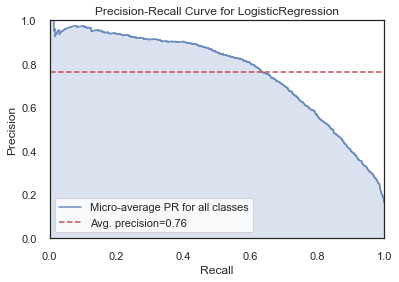

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


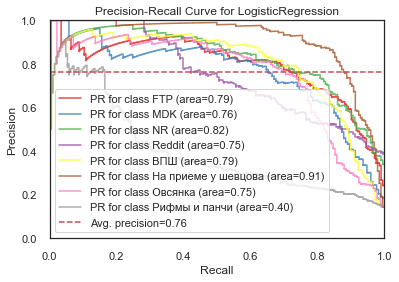

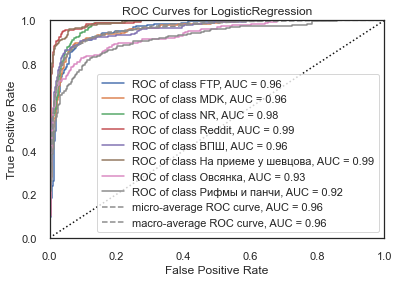

In [464]:
stat_of_clf(best_estim, X_train, y_train, X_test, y_test)

Заметим, что больше всего алгоритм ошибается на группе "Рифмы и панчи", это может быть из за того, что группа постепенно отходит от музыкальной повестки и начинает освещать новости, как и все остальные группы в этом списке

## SVM

SVM зачастую лучше подходит для классификации, так как SVM имеет более сбалансированную границу между двумя категориями и он более устойчив к выбросам в данных

In [467]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.7825512227362855

In [468]:
params = [    
    {'C' :[17],
     'kernel':['rbf', 'sigmoid'],
     'gamma':['auto'],
     'probability':[True]
    }
]

In [469]:
clf2 = validation(model=svm.SVC(), params=params, X=X_train, y=y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [470]:
best_estim2 = clf2.best_estimator_
print(clf2.best_score_)
print(clf2.best_params_)

0.7805287618319673
{'C': 17, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}


Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,167,13,11,8,1,0,2,1,203
MDK,23,136,6,3,0,1,1,3,173
NR,10,5,163,3,0,2,1,9,193
Reddit,12,11,1,152,1,3,0,0,180
ВПШ,6,0,10,0,144,4,10,5,179
На приеме у шевцова,1,0,2,2,11,175,2,3,196
Овсянка,10,5,9,8,2,1,139,9,183
Рифмы и панчи,6,14,9,8,8,6,26,129,206
All,235,184,211,184,167,192,181,159,1513


                     precision    recall  f1-score   support

                FTP       0.71      0.82      0.76       203
                MDK       0.74      0.79      0.76       173
                 NR       0.77      0.84      0.81       193
             Reddit       0.83      0.84      0.84       180
                ВПШ       0.86      0.80      0.83       179
На приеме у шевцова       0.91      0.89      0.90       196
            Овсянка       0.77      0.76      0.76       183
      Рифмы и панчи       0.81      0.63      0.71       206

           accuracy                           0.80      1513
          macro avg       0.80      0.80      0.80      1513
       weighted avg       0.80      0.80      0.80      1513

One-vs-One ROC AUC scores:
0.970987 (macro),
0.970818 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.970858 (macro),
0.970646 (weighted by prevalence)


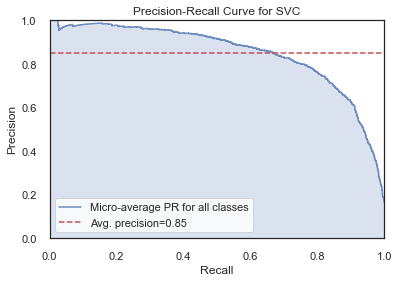

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


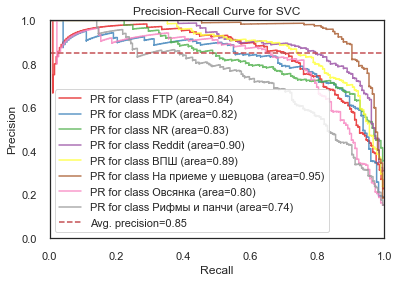

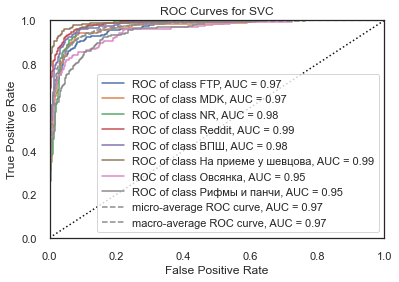

In [471]:
stat_of_clf(best_estim2, X_train, y_train, X_test, y_test)

## Decision tree 

In [472]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.7316589557171183

In [476]:
params = [    
    {'criterion':['gini', 'entropy'],
     'max_depth':range(100, 1000, 100),
     'min_samples_split':[2,7,9],
     'min_samples_leaf':[2, 4, 5],
    }
]

In [477]:
clf3 = validation(model=DecisionTreeClassifier(), params=params, X=X_train, y=y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  1.3min finished


In [478]:
best_estim3 = clf3.best_estimator_
print(clf3.best_score_)
print(clf3.best_params_)


0.7516098300018427
{'criterion': 'entropy', 'max_depth': 800, 'min_samples_leaf': 4, 'min_samples_split': 9}


Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,147,21,8,9,1,0,13,4,203
MDK,21,129,6,4,0,1,5,7,173
NR,3,4,158,1,2,0,8,17,193
Reddit,10,10,0,154,0,2,0,4,180
ВПШ,2,1,7,0,150,6,9,4,179
На приеме у шевцова,0,2,3,6,10,164,2,9,196
Овсянка,4,19,3,0,8,1,132,16,183
Рифмы и панчи,3,14,18,6,19,7,23,116,206
All,190,200,203,180,190,181,192,177,1513


                     precision    recall  f1-score   support

                FTP       0.77      0.72      0.75       203
                MDK       0.65      0.75      0.69       173
                 NR       0.78      0.82      0.80       193
             Reddit       0.86      0.86      0.86       180
                ВПШ       0.79      0.84      0.81       179
На приеме у шевцова       0.91      0.84      0.87       196
            Овсянка       0.69      0.72      0.70       183
      Рифмы и панчи       0.66      0.56      0.61       206

           accuracy                           0.76      1513
          macro avg       0.76      0.76      0.76      1513
       weighted avg       0.76      0.76      0.76      1513

One-vs-One ROC AUC scores:
0.913603 (macro),
0.913117 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.913456 (macro),
0.912514 (weighted by prevalence)


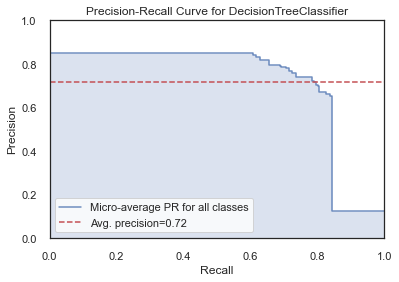

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


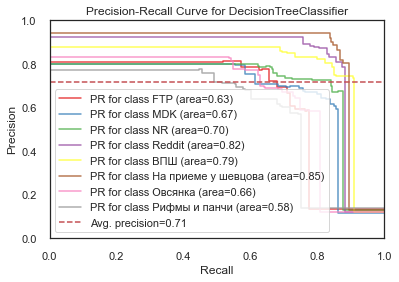

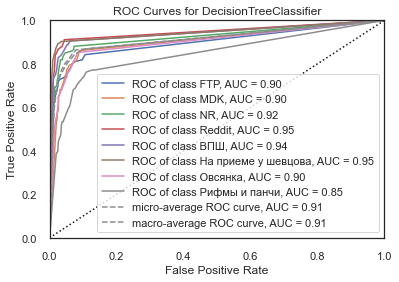

In [479]:
stat_of_clf(best_estim3, X_train, y_train, X_test, y_test)

## Random forest

Хороший алгоритм классификации, в отличие от дерева решений он устойчив к переобучению.

In [486]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.score(X_test, y_test)

0.8288169200264376

Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,162,15,10,6,1,0,5,4,203
MDK,13,137,8,5,0,1,3,6,173
NR,2,1,177,1,0,0,0,12,193
Reddit,6,9,0,162,0,2,0,1,180
ВПШ,3,0,11,0,152,3,6,4,179
На приеме у шевцова,0,0,3,1,7,179,1,5,196
Овсянка,8,6,9,0,10,0,142,8,183
Рифмы и панчи,2,7,7,8,9,8,22,143,206
All,196,175,225,183,179,193,179,183,1513


                     precision    recall  f1-score   support

                FTP       0.83      0.80      0.81       203
                MDK       0.78      0.79      0.79       173
                 NR       0.79      0.92      0.85       193
             Reddit       0.89      0.90      0.89       180
                ВПШ       0.85      0.85      0.85       179
На приеме у шевцова       0.93      0.91      0.92       196
            Овсянка       0.79      0.78      0.78       183
      Рифмы и панчи       0.78      0.69      0.74       206

           accuracy                           0.83      1513
          macro avg       0.83      0.83      0.83      1513
       weighted avg       0.83      0.83      0.83      1513

One-vs-One ROC AUC scores:
0.977819 (macro),
0.977730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.977806 (macro),
0.977634 (weighted by prevalence)


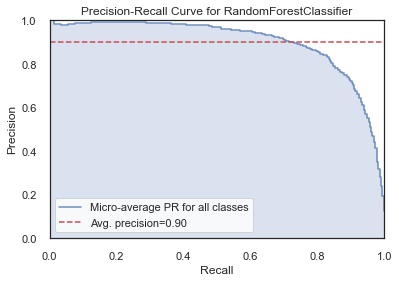

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


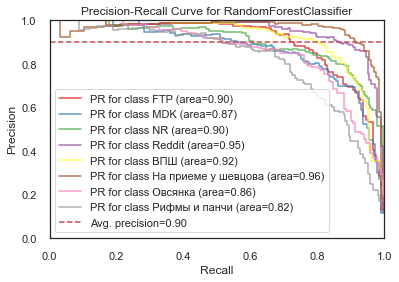

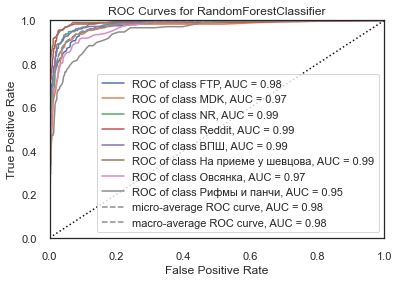

In [491]:
stat_of_clf(forest_clf, X_train, y_train, X_test, y_test)

In [487]:
params = [ {   
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [800, 1000]}
]


In [488]:
clf4 = validation(model=RandomForestClassifier(), params=params, X=X_train, y=y_train, cv=3)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 11.2min finished


In [489]:
best_estim4 = clf4.best_estimator_
print(clf4.best_score_)
print(clf4.best_params_)


0.816724508345728
{'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,161,16,11,6,1,0,6,2,203
MDK,16,137,7,4,0,0,4,5,173
NR,4,2,174,0,0,0,0,13,193
Reddit,5,9,0,160,0,4,0,2,180
ВПШ,2,0,12,0,153,3,5,4,179
На приеме у шевцова,0,0,3,1,8,177,1,6,196
Овсянка,8,5,10,0,7,0,146,7,183
Рифмы и панчи,2,7,6,6,7,7,24,147,206
All,198,176,223,177,176,191,186,186,1513


                     precision    recall  f1-score   support

                FTP       0.81      0.79      0.80       203
                MDK       0.78      0.79      0.79       173
                 NR       0.78      0.90      0.84       193
             Reddit       0.90      0.89      0.90       180
                ВПШ       0.87      0.85      0.86       179
На приеме у шевцова       0.93      0.90      0.91       196
            Овсянка       0.78      0.80      0.79       183
      Рифмы и панчи       0.79      0.71      0.75       206

           accuracy                           0.83      1513
          macro avg       0.83      0.83      0.83      1513
       weighted avg       0.83      0.83      0.83      1513

One-vs-One ROC AUC scores:
0.979709 (macro),
0.979618 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.979701 (macro),
0.979518 (weighted by prevalence)


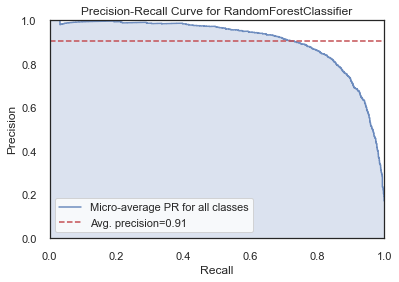

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


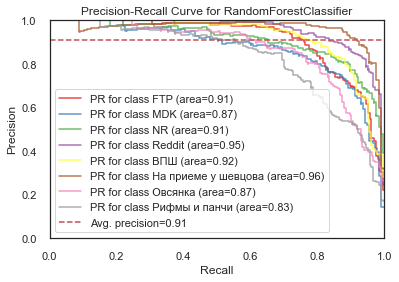

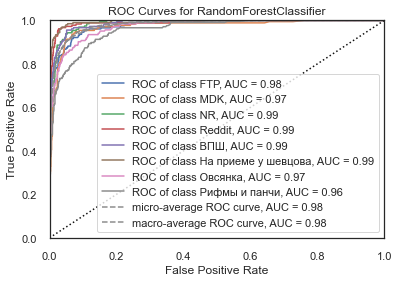

In [490]:
stat_of_clf(best_estim4, X_train, y_train, X_test, y_test)

Интересно, что baseline модель оказалась лучше.

<AxesSubplot:>

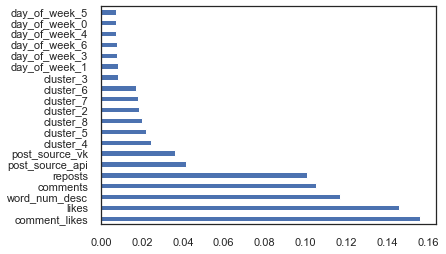

In [492]:

feat_importances = pd.Series(forest_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')


## K neghbours

In [493]:
n_clf = KNeighborsClassifier()
n_clf.fit(X_train, y_train)
n_clf.score(X_test, y_test)

0.6510244547257105

In [494]:
params = [    
    {'weights': ['uniform', 'distance'] ,
     'n_neighbors': range(2, 25)
    }
]


In [495]:
clf5 = validation(model=KNeighborsClassifier(), params=params, X=X_train, y=y_train, cv=5)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:   38.5s finished


In [496]:
best_estim5 = clf5.best_estimator_
print(clf5.best_score_)
print(clf5.best_params_)

0.6998809808163461
{'n_neighbors': 24, 'weights': 'uniform'}


Predicted,FTP,MDK,NR,Reddit,ВПШ,На приеме у шевцова,Овсянка,Рифмы и панчи,All
Actual,,,,,,,,,
FTP,163,11,8,14,1,0,4,2,203
MDK,20,126,6,11,0,0,5,5,173
NR,16,10,153,4,0,2,0,8,193
Reddit,29,14,2,126,0,4,1,4,180
ВПШ,10,0,12,0,113,14,27,3,179
На приеме у шевцова,3,0,7,2,12,169,1,2,196
Овсянка,16,2,13,5,8,3,130,6,183
Рифмы и панчи,14,23,23,16,4,10,33,83,206
All,271,186,224,178,138,202,201,113,1513


                     precision    recall  f1-score   support

                FTP       0.60      0.80      0.69       203
                MDK       0.68      0.73      0.70       173
                 NR       0.68      0.79      0.73       193
             Reddit       0.71      0.70      0.70       180
                ВПШ       0.82      0.63      0.71       179
На приеме у шевцова       0.84      0.86      0.85       196
            Овсянка       0.65      0.71      0.68       183
      Рифмы и панчи       0.73      0.40      0.52       206

           accuracy                           0.70      1513
          macro avg       0.71      0.70      0.70      1513
       weighted avg       0.71      0.70      0.70      1513

One-vs-One ROC AUC scores:
0.940369 (macro),
0.940033 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.940236 (macro),
0.939649 (weighted by prevalence)


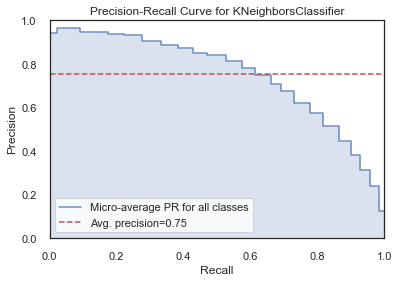

C:\Users\User\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


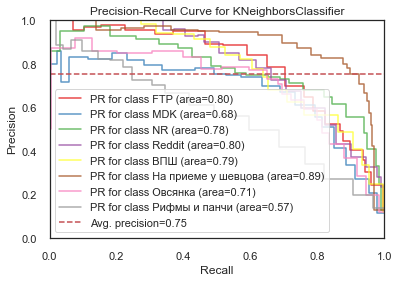

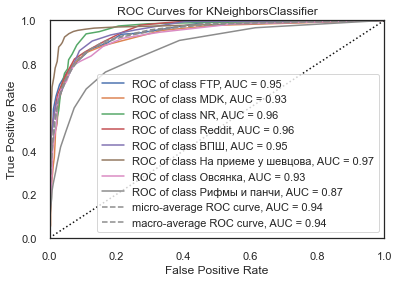

In [497]:
stat_of_clf(best_estim5, X_train, y_train, X_test, y_test)